# Flight Delay Analysis -The case study of Nok Airine
## Introduction
Flight Delay Analysis is a personal project to analyze airline historical data, particularly flight delay.

#### Project Goals:
This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis to answer the questions related to delayed flight
Some questions that are posed:
>* What is the most delayed flight?
>* Is there a specific time of the day that delay occoured more often?
>* Which airport has more chance of delayed flight?
>* Are there any specific aircraft that prone to delay?

## Data
#### Data sources:
The data.csv was scraped with beautifulsoup4 from flightradar24.com. The data contain 7 days flight history of Nok Airline's fleet.<br>
Note:
>* According to flightradar24.com/robots.txt, data scraping is not allowed in particular part of the website which /data/aircraft in excluded. In addition, this project only need a few connection to scrape the data to minimize the load to the website.
>* The data was scraped and created on January 27, 2023. 
>* This project used 'Departure Delay' to calculate delay of the flight. The calculation can be done by get the different between Actual Departure Time and Schedual Departure Time (STD). Noted that the departure delay can caused by many factors (e.g. delayed from the previous flight, air traffic congestion, aircraft mulfunction, ground handling issue, etc. which might not always related to airline's performance).

#### Import Python Modules
First, import the primary modules that will be used in this project:

In [334]:
import datetime
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#### Scraping data and creating data.csv
To scraping data, this project use beautifulsoup4 and loop through each aircraft in Nok Air fleet. Then create data.csv file to stored the data for later use.

In [335]:
def create_flight_data_csv():
    ac_list = ["DBG", "DBK", "DBO", "DBP", "DBQ", "DBS", "BDT", "DBU", "DBV", "DBW", "DBX", "DBY", "DBZ", "DQA", "DQB",
               "DQF"]

    headers = {
        "Accept-Language": "en-GB,en;q=0.9,th-TH;q=0.8,th;q=0.7,en-US;q=0.6",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36", }

    data = {
        "Date": [],
        "Flight Number": [],
        "A/C": [],
        "From": [],
        "From (IATA)": [],
        "To": [],
        "To (IATA)": [],
        "STD": [],
        "ATD": [],
        "STA": [],
        "ATA": [],
        "Flight Time (Schedual)": [],
        "Flight Time (Actual)": [],
        "Delay (Departure)": [],
        "Is Weekday": [],
    }
    df = pd.DataFrame.from_dict(data, orient="columns")
    df.to_csv('data.csv', mode='w', index=False, header=True, encoding="utf-8-sig")

    for ac in ac_list:
        url = f"https://www.flightradar24.com/data/aircraft/hs-{ac.lower()}"
        response = requests.get(url=url, headers=headers)
        bs = BeautifulSoup(response.text, "html.parser")

        for tr in bs.find_all(class_="data-row"):
            row = [td.text for td in tr.find_all('td')]
            flight_status = row[11].split(" ")[1]
            if flight_status == "Landed" and row[8].strip() != "—":
                date = pd.to_datetime(row[0].split("  ")[1])
                flight_no = row[5].strip()
                aircraft = f"HS-{ac}"
                fly_from = row[0].split("  ")[10].strip().split("(")[0]
                fly_from_iata = row[0].split("  ")[10].strip().split("(")[1][0:3]
                fly_to = row[0].split("  ")[12].strip().split("(")[0]
                fly_to_iata = row[0].split("  ")[12].strip().split("(")[1][0:3]
                std = datetime.datetime.strptime(row[7].strip(), "%H:%M") + datetime.timedelta(hours=7)
                atd = datetime.datetime.strptime(row[8].strip(), "%H:%M") + datetime.timedelta(hours=7)
                sta = datetime.datetime.strptime(row[9].strip(), "%H:%M") + datetime.timedelta(hours=7)
                ata = datetime.datetime.strptime(row[11].split(" ")[2], "%H:%M") + datetime.timedelta(hours=7)
                sched_flight_time = sta - std
                actual_flight_time = ata - atd
                delay = atd - std
                if sched_flight_time < datetime.timedelta(hours=0):
                    sched_flight_time += datetime.timedelta(hours=24)
                if actual_flight_time < datetime.timedelta(hours=0):
                    actual_flight_time += datetime.timedelta(hours=24)
                if delay <= datetime.timedelta(hours=0):
                    delay = datetime.timedelta(hours=0)
                if date.weekday() >= 5:
                    weekday = False
                else:
                    weekday = True
                data["Date"].append(date)
                data["Flight Number"].append(flight_no)
                data["A/C"].append(aircraft)
                data["From"].append(fly_from)
                data["From (IATA)"].append(fly_from_iata)
                data["To"].append(fly_to)
                data["To (IATA)"].append(fly_to_iata)
                data["STD"].append(std)
                data["ATD"].append(atd)
                data["STA"].append(sta)
                data["ATA"].append(ata)
                data["Flight Time (Schedual)"].append(sched_flight_time)
                data["Flight Time (Actual)"].append(actual_flight_time)
                data["Delay (Departure)"].append(delay)
                data["Is Weekday"].append(weekday)

        df = pd.DataFrame.from_dict(data, orient="columns")
        df.to_csv('data.csv', mode='a', index=False, header=False, encoding="utf-8-sig")

# create_flight_data_csv()

#### Loading the Data
To analyze the flight data and delay of the flight(s), load the datasets into DataFrames.

The data.csv contains data of flight history for the past 7 days. The columns in the data set include:
>* Date- Date of flight
>* Flight Number- Combination of the airline's IATA code and 3 digits number
>* A/C- Aircraft registration
>* From- Departure airport
>* From (IATA)- Departure airport in IATA code
>* To- Destination airport
>* To (Iata)- Destination airport in IATA code
>* STD- Scheduled Time of Departure (GMT+7)
>* ATD- Actual Time of Departure (GMT+7)
>* STA- Scheduled Time of Arrival (GMT+7)
>* ATA- Actual time of Arrival (GMT+7)
>* Flight Time (Schedual)- Schedual flight time (STA-STD)
>* Flight Time (Actual) - Actual flight time (ATA-ATD)
>* Delay (Departure) - Departure delay (ATD-STD)
>* Is Weekday - True=Weekday, False=Weekend
#### Explore the Data

In [336]:
data = pd.read_csv('data.csv',encoding='utf-8')
data.head()

,Date,Flight Number,A/C,From,From (IATA),To,To (IATA),STD,ATD,STA,ATA,Flight Time (Schedual),Flight Time (Actual),Delay (Departure),Is Weekday
0,2023-01-27,DD106,HS-DBG,Bangkok,DMK,Chiang Rai,CEI,1900-01-01 13:40:00,1900-01-01 14:36:00,1900-01-01 15:05:00,1900-01-01 15:36:00,0 days 01:25:00,0 days 01:00:00,0 days 00:56:00,True
1,2023-01-27,DD503,HS-DBG,Hat Yai,HDY,Bangkok,DMK,1900-01-01 11:35:00,1900-01-01 12:23:00,1900-01-01 13:35:00,1900-01-01 13:34:00,0 days 02:00:00,0 days 01:11:00,0 days 00:48:00,True
2,2023-01-27,DD502,HS-DBG,Bangkok,DMK,Hat Yai,HDY,1900-01-01 09:40:00,1900-01-01 10:30:00,1900-01-01 11:40:00,1900-01-01 11:39:00,0 days 02:00:00,0 days 01:09:00,0 days 00:50:00,True
3,2023-01-27,DD361,HS-DBG,Sakon Nakhon,SNO,Bangkok,DMK,1900-01-01 08:40:00,1900-01-01 08:48:00,1900-01-01 09:45:00,1900-01-01 09:39:00,0 days 01:05:00,0 days 00:51:00,0 days 00:08:00,True
4,2023-01-27,DD360,HS-DBG,Bangkok,DMK,Sakon Nakhon,SNO,1900-01-01 07:00:00,1900-01-01 07:17:00,1900-01-01 08:10:00,1900-01-01 08:13:00,0 days 01:10:00,0 days 00:56:00,0 days 00:17:00,True


In [337]:
print(f"Data shape: {data.shape}")

Data shape: (5724, 15)


The data shape show how many flights was conducted in the past 7 days.

In [338]:
print(f"Fleet size: {data['A/C'].nunique()}")
print(f"Aircraft list: {data['A/C'].unique()}")

Fleet size: 13
Aircraft list: ['HS-DBG' 'HS-DBO' 'HS-DBP' 'HS-DBS' 'HS-DBU' 'HS-DBV' 'HS-DBW' 'HS-DBX'
 'HS-DBY' 'HS-DBZ' 'HS-DQA' 'HS-DQB' 'HS-DQF']


This show active fleet size and aircrafts list in registration.

In [339]:
data.groupby('To').size().sort_values(ascending=False)

To
Bangkok                 2808
Chiang Mai               586
Phuket                   376
Udon Thani               261
Hat Yai                  255
Chiang Rai               244
Nakhon Si Thammarat      196
Ubon Ratchathani         195
Sakon Nakhon             124
Nan                      118
Surat Thani              116
Ho Chi Minh City         110
Phitsanulok               94
Trang                     48
Nakhon Phanom             46
Yangon                    44
Loei                      32
Buriram                   15
Zhengzhou                 13
Nanning                   13
Mae Sot                    9
Mae Hong Son               8
Lampang                    6
Phrae                      5
Chumphon                   2
dtype: int64

Most frequent flight destination is Bangkok, which is Nok Airline homebase and also an outlier to be notice in the further analysis.

## Analysis
This section will begin analyzing the data after the initial exploration.

For clearer interpretation, change the value of column 'Is Weekday' to 'Weekday' and 'Weekend'.

In [340]:
data['Day of Week'] = data['Is Weekday'].apply(lambda x: 'Weekday' if x == True else 'Weekend')
data['Day of Week'].unique()

array(['Weekday', 'Weekend'], dtype=object)

In [341]:
data['Is Delay'] = data['Delay (Departure)'].apply(lambda x: 'Delayed' if pd.Timedelta(x) > datetime.timedelta(minutes=30) else 'On Time')
print("Number of Flight On Time vs Delay")
print(data['Is Delay'].value_counts())
print("--------------------")
print("On Time vs Delay Proportion")
print(round(100*data['Is Delay'].value_counts()/data['Is Delay'].value_counts().sum(), 2))

Number of Flight On Time vs Delay
On Time    3289
Delayed    2435
Name: Is Delay, dtype: int64
--------------------
On Time vs Delay Proportion
On Time    57.46
Delayed    42.54
Name: Is Delay, dtype: float64


In [342]:
data['STD'] = pd.to_datetime(data['STD'])
data['ATD'] = pd.to_datetime(data['ATD'])
data['STA'] = pd.to_datetime(data['STA'])
data['ATA'] = pd.to_datetime(data['ATA'])

In [343]:
most_delay = data[data['Delay (Departure)']==data['Delay (Departure)'].max()]
for (index, row) in most_delay.iterrows():
    most_delay_date = row['Date']
    most_delay_flight = row['Flight Number']
    most_delay_fly_from = row['From']
    most_delay_fly_to = row['To']
    most_delay_total_delay = row['Delay (Departure)']
print(f"Most Delay flight in the past 7 days was on {most_delay_date}.\nFlight {most_delay_flight} from {most_delay_fly_from} to {most_delay_fly_to}.\nTotal delay: {most_delay_total_delay}.")

Most Delay flight in the past 7 days was on 2023-01-26.
Flight DD506 from Bangkok  to Hat Yai .
Total delay: 0 days 04:15:00.


[Text(0, 0, '7'),
 Text(1, 0, '8'),
 Text(2, 0, '9'),
 Text(3, 0, '10'),
 Text(4, 0, '11'),
 Text(5, 0, '12'),
 Text(6, 0, '13'),
 Text(7, 0, '14'),
 Text(8, 0, '15'),
 Text(9, 0, '16'),
 Text(10, 0, '17'),
 Text(11, 0, '18'),
 Text(12, 0, '19'),
 Text(13, 0, '20'),
 Text(14, 0, '21'),
 Text(15, 0, '22')]

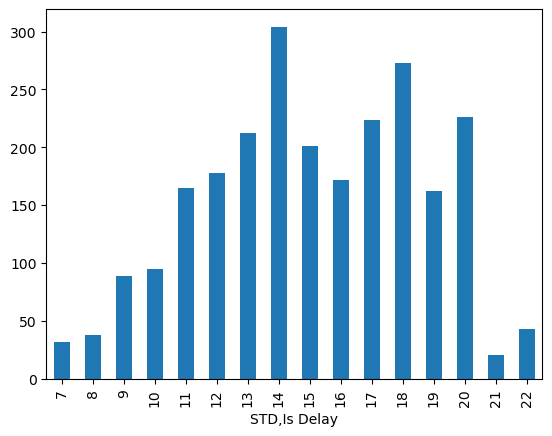

In [344]:
delay = data[data['Is Delay'] == 'Delayed'].groupby(data['STD'].dt.hour)['Is Delay'].value_counts()
ax = plt.subplot()
delay.plot(kind='bar', stacked=True)
ax.set_xticklabels(range(7,23))

According to the plot, number of delayed flight increasing as the time goes by and peaked at 14:00. After that the number of delayed flight decreased in a small-scale then immediately drop after 20:00.

In [345]:
delay_by_std = data.groupby(data['STD'].dt.hour)['Is Delay'].value_counts().unstack().fillna(0).astype(int)
delay_by_std_percent = round(100*delay_by_std.div(delay_by_std.sum(axis=1), axis=0), 2)

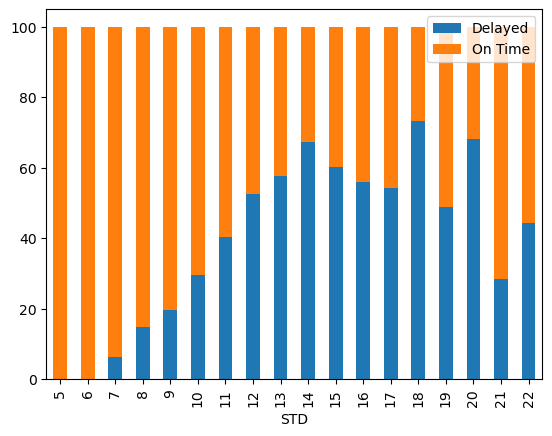

In [346]:
delay_by_std_percent.plot(kind='bar', stacked=True)
plt.legend(loc=1)

To get a better view of the number of delayed flight proportion to the number of total flight. This plot show increasing in proportion of delayed flight as the time goes by.

In [347]:
delay_by_airport = data.groupby(data['To'])['Is Delay'].value_counts().unstack().fillna(0).astype(int)
delay_by_airport_percent = round(100*delay_by_airport.div(delay_by_airport.sum(axis=1), axis=0), 2)

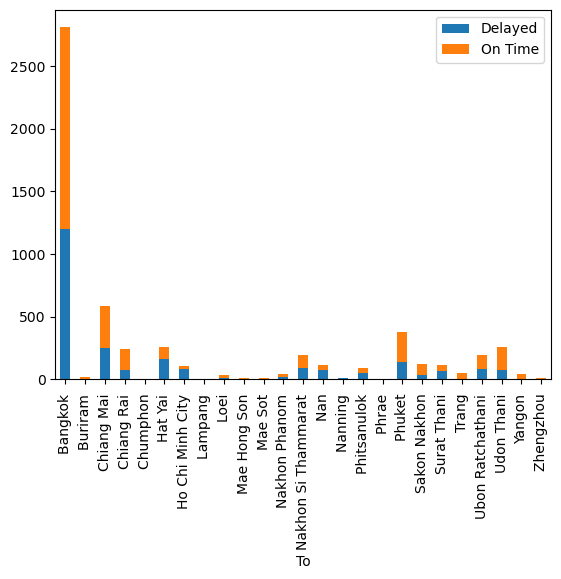

In [348]:
delay_by_airport.plot(kind='bar', stacked=True)
plt.legend(loc=1)

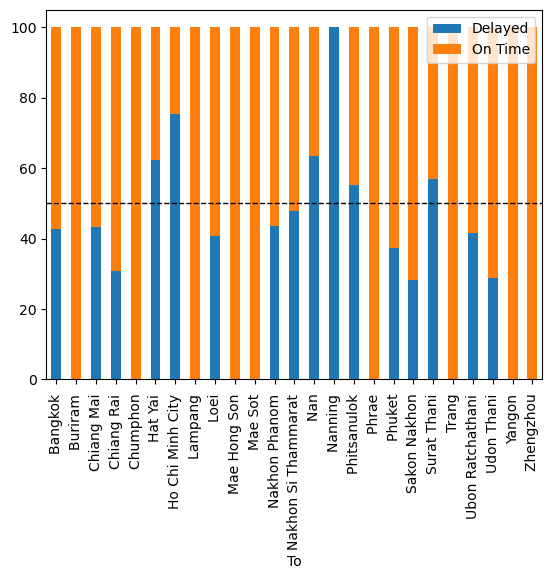

In [349]:
delay_by_airport_percent.plot(kind='bar', stacked=True)
plt.axhline(y=50,linewidth=1, color='k', linestyle='--')
plt.legend(loc=1)

This plot show the proportion of delayed flight and on time flight by airport. The dashed line is the 50%. The airport that has the proportion of delayed flight indicated that the delayed are more likely to occurred.

In [350]:
delay_by_ac = data.groupby(data['A/C'])['Is Delay'].value_counts().unstack().fillna(0).astype(int)
delay_by_ac_percent = round(100*delay_by_ac.div(delay_by_ac.sum(axis=1), axis=0), 2)

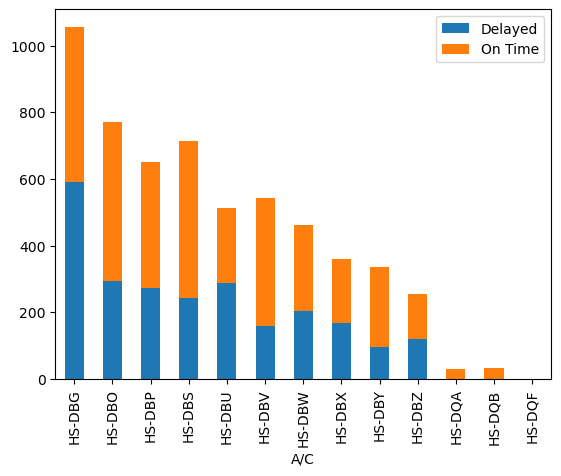

In [351]:
delay_by_ac.plot(kind='bar', stacked=True)
plt.legend(loc=1)

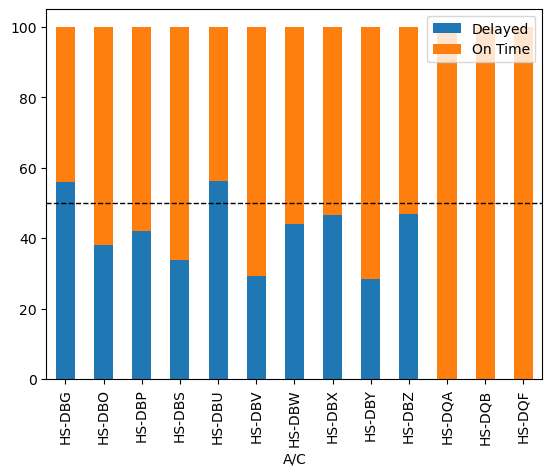

In [352]:
delay_by_ac_percent.plot(kind='bar', stacked=True)
plt.axhline(y=50,linewidth=1, color='k', linestyle='--')
plt.legend(loc=1)

According to the plot, HS-DBG and HS-DBU delay proportion are slightly about 50% line. Overall, there are not significant delayed flight in any specific aircraft.<br>
Note that HS-DQA, HS-DQB and HS-DQF have no delayed flight but since the sample sizes (the number of flight) are small, it's not certain that these 3 aircrafts are not prone to delay.

## Conclusions
The project was able to make several data visualizations and inferences about the flight history data that comprised this data set.
This project was also able to answer some of the questions first posed in the beginning:

* What is the most delayed flight?
>* The most delay flight in the past 7 days was on January 26, 2023. The flight was from Bangkok to Hat Yai. Flight number is DD506. The total delay: 04:15 hours.
* Is there a specific time of the day that delay occoured more often?
>* The number of delayed flight increase as the time of the day goes by. The peak are 14:00, 18:00 and 20:00. However, the number of delayed flight and the delay proportion drop drastically after 20:00.
* Which airport has more chance of delayed flight?
>* Nanning is the outlier airport which has 100% delayed flight. Moreover, Ho Chi Minh, Nan, Hat Yai, Surat Thani and Phitsanulok airport are the group of airports that passed the 50% proportion mark.
* Are there any specific aircraft that prone to delay?
>* HS-DBG and HS-DBU are proned to delay slightly above 50%. Overall, there are not significant delayed flight in any specific aircraft.

## Further Research

This dataset only inclded the flight history of Nok Airline in the past 7 days which prohibits analyze changes over time, comparision to other airlines and limited amout of data. There are many data set that can added to the research to improve the analysis even more such as airport capacity, number of passenger and aircraft age (elapsed months of an Aircraft since its date of manufacture). Lastly, this reserch intention is to give overview of flight history data and delay which not and can not reflected the airline performance.